In [1]:
import numpy as np
import ase.build
from ase.build import bulk
import abtem
import matplotlib.pyplot as plt

from pathlib import Path
import sys
# add parent folder (and common src folder) to sys.path so imports can be resolved
parent = Path.cwd().parent
candidates = [parent, parent / "src"]
for p in candidates:
    if p.exists() and str(p) not in sys.path:
        sys.path.insert(0, str(p))

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".9"

from jax_multislice import (
    get_abtem_transmit, 
    Propagator as convolve2d, 
    energy2wavelength, 
    fresnel_propagation_kernel, 
    electron_refractive_index,
    wpm_step_adaptive,
    )

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
%matplotlib widget

abtem.config.set({"device": "gpu"})

In [2]:
# --- 1. Setup Parameters ---
# The precise experimental vector from the paper
experimental_vector = [0.559845, 0.827639, 0.03982]
experimental_vector = experimental_vector / np.linalg.norm(experimental_vector) # Ensure unit length
plot_gamma = 0.4                # Power-law for diffraction visualization
max_angle_mrad = 22.0
# The nearest integer zone axis (Crucial for periodic boundaries)
zone_axis_int = [2, 3, 0] 

# --- 2. Build & Rotate Crystal Correctly ---
atoms = bulk("Si", "diamond", a=5.431, cubic=True)

# A: Align the crystal to the INTEGER axis (keeps the simulation box small)
atoms.rotate(zone_axis_int, 'z', rotate_cell=True)

# B: Orthogonalize (Now safe because we used integers)
atoms = abtem.orthogonalize_cell(atoms)

# C: Set Thickness (repeat in Z)
slice_height = atoms.cell[2, 2]
desired_thickness_A = 93.74 * 10 
repeats_z = int(np.ceil(desired_thickness_A / slice_height))
atoms = atoms * (5, 6, repeats_z) # 6x6 lateral is usually enough for CBED

# --- 3. Calculate the Beam Tilt ---
# We need to tilt the BEAM to compensate for the fact that we didn't 
# rotate the crystal to the exact experimental vector.

# Calculate the angle between the Integer Axis (Z) and Experimental Vector
# We project the experimental vector onto the x, y plane of the crystal.
# Since we aligned zone_axis_int to Z, we just need to rotate the experimental 
# vector into this new coordinate system to find the tilt components.

# Create a rotation matrix that aligns zone_axis_int to [0,0,1]
# (This matches what atoms.rotate did)
from scipy.spatial.transform import Rotation
z_target = np.array(zone_axis_int) / np.linalg.norm(zone_axis_int)

# A robust way to get the rotation matrix that was applied to atoms:
# Vector_Z_old -> Vector_Z_new
# We can just calculate the required tilt (kx, ky) in mrad directly:
# Tilt angle theta = acos( dot(z_int, z_exp) )
# The direction of tilt is given by the transverse components.

# ...Or simpler: Let abTEM handle the angle calculation via 'PlaneWave' or 'Probe'
# by defining the tilt in mrad.

# Calculate mis-tilt angles in x and y (approximate for small angles)
# First, rotate the experimental vector by the same rotation we applied to atoms
# We need to construct that rotation:
vec_z = z_target
vec_x = np.cross([0,1,0], vec_z) # Arbitrary X
if np.linalg.norm(vec_x) < 1e-5: vec_x = np.cross([1,0,0], vec_z)
vec_x /= np.linalg.norm(vec_x)
vec_y = np.cross(vec_z, vec_x)
R_matrix = np.vstack([vec_x, vec_y, vec_z]) # Rotation matrix from Crystal to Lab

# Rotate the experimental vector into the simulation frame
v_exp_lab = R_matrix @ experimental_vector 

# Extract tilts (tan(theta) ~ theta for small angles)
# v_exp_lab should be close to [0, 0, 1]. The x and y components are the tilts.
tilt_x = np.arcsin(v_exp_lab[0]) * 1000 # in mrad
tilt_y = np.arcsin(v_exp_lab[1]) * 1000 # in mrad

print(f"Computed Beam Tilts -> x: {tilt_x:.3f} mrad, y: {tilt_y:.3f} mrad")

energy=202.406e3  # eV
wavelength = energy2wavelength(energy)  # in Angstroms

# --- 4. Run Simulation with Tilt ---
# Now you apply this tilt to your Probe
probe = abtem.Probe(
    energy=202.406e3, 
    semiangle_cutoff=9.6883, # From paper (alpha_cv)
    tilt=(tilt_x, tilt_y),   # <--- APPLY TILT HERE
    # ... other probe params ...
)

Computed Beam Tilts -> x: -39.831 mrad, y: -6.728 mrad


W1219 15:10:33.093268 2907259 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1219 15:10:33.100181 2906856 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [3]:
from tqdm import trange

def simulate_pattern_fresnel(potential, probe, prop_kernel, dz):
    wavefront = probe
    wavefronts = []

    for i in trange(potential.shape[0]):
        n = electron_refractive_index(potential[i], energy)
        phase_shift = jnp.exp(1j * 2 * jnp.pi * (n - 1) * dz / wavelength)
        wavefront = wavefront * phase_shift
        wavefront = convolve2d(wavefront, prop_kernel)
        wavefronts.append(wavefront)
    
    exit_wave = wavefront
    
    detector_wavefront = jnp.fft.fftshift(jnp.fft.fft2(wavefront))
    diffraction_pattern = (
        jnp.square(detector_wavefront.real)
        + jnp.square(detector_wavefront.imag)
    )
    return exit_wave, diffraction_pattern, jnp.stack(wavefronts)


simulate_pattern_fresnel_jit = jax.jit(simulate_pattern_fresnel)


def simulate_pattern_wpm_binning(potential, probe, dz, energy, ps):
    wavefront = probe
    wavefronts = []
    for i in trange(potential.shape[0], desc="WPM binning slices"):
        n = electron_refractive_index(potential[i], energy)
        wavefront, _, _, _ = wpm_step_adaptive(wavefront, n, dz, energy, ps, n_bins=128)
        wavefronts.append(wavefront)
    
    exit_wave = wavefront
    
    detector_wavefront = jnp.fft.fftshift(jnp.fft.fft2(wavefront))
    diffraction_pattern = (
        jnp.square(detector_wavefront.real)
        + jnp.square(detector_wavefront.imag)
    )
    return exit_wave, diffraction_pattern, jnp.stack(wavefronts)


simulate_pattern_wpm_binning_jit = jax.jit(simulate_pattern_wpm_binning)


def max_angle_gpts(shape, sampling, wavelength, max_angle_mrad, parity="odd"):
    """Return the cropped grid size matching max_angle_mrad."""
    ny, nx = shape
    dx, dy = float(sampling[0]), float(sampling[1])
    max_freq = float(max_angle_mrad) / (float(wavelength) * 1000.0)
    dfx = 1.0 / (nx * dx)
    dfy = 1.0 / (ny * dy)
    half_x = int(np.floor(max_freq / dfx))
    half_y = int(np.floor(max_freq / dfy))
    half_x = max(0, min(half_x, nx // 2))
    half_y = max(0, min(half_y, ny // 2))
    if parity == "even":
        new_nx = 2 * half_x
        new_ny = 2 * half_y
    else:
        new_nx = 2 * half_x + 1
        new_ny = 2 * half_y + 1
    new_nx = max(1, min(new_nx, nx))
    new_ny = max(1, min(new_ny, ny))
    return new_ny, new_nx


def downsample_to_max_angle(pattern, sampling, wavelength, max_angle_mrad, parity="odd"):
    """Center-crop a fftshifted diffraction pattern to max_angle_mrad."""
    arr = np.asarray(pattern)
    ny, nx = arr.shape
    new_ny, new_nx = max_angle_gpts(arr.shape, sampling, wavelength, max_angle_mrad, parity=parity)
    if (new_ny, new_nx) == (ny, nx):
        return arr
    cy, cx = ny // 2, nx // 2
    y0 = cy - new_ny // 2
    x0 = cx - new_nx // 2
    return arr[y0:y0 + new_ny, x0:x0 + new_nx]


In [4]:
# --- Consolidated computation (abTEM, Fresnel, WPM) ---
slice_thickness = 0.5  # Angstroms
semi_angle_cutoff = 9.6883  # mrad
potential = abtem.Potential(
    atoms,
    sampling=1.0,
    slice_thickness=slice_thickness,
    parametrization='lobato',
    projection='infinite',
)
potential_array = potential.build(lazy=False).array / slice_thickness

probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semi_angle_cutoff,
)
probe.grid.match(potential)
probe_array = probe.build(lazy=False).array

# abTEM: diffraction pattern and exit wave
cbed_pattern = probe.multislice(potential).diffraction_patterns(max_angle=max_angle_mrad)
cbed_pattern.compute()
diffraction_pattern_abtem = cbed_pattern.array

exit_wave_abtem = probe.multislice(
    potential,
    detectors=abtem.WavesDetector(),
    lazy=False,
).array

# Fresnel and WPM
sampling = (float(probe.grid.sampling[0]), float(probe.grid.sampling[1]))
fresnel_propagator = fresnel_propagation_kernel(
    probe.grid.gpts[0],
    probe.grid.gpts[1],
    sampling,
    z=slice_thickness,
    energy=probe.energy,
)

potential_array = jnp.array(potential_array)
probe_array = jnp.array(probe_array)
exit_wave_fresnel, diffraction_pattern_fresnel, wavefronts_fresnel = simulate_pattern_fresnel(
    potential_array, probe_array, fresnel_propagator, slice_thickness
)
exit_wave_wpm, diffraction_pattern_wpm, wavefronts_wpm = simulate_pattern_wpm_binning(
    potential_array, probe_array, slice_thickness, energy, sampling
)


[########################################] | 100% Completed | 23.77 ss


WPM binning slices: 100%|██████████| 1886/1886 [00:21<00:00, 87.97it/s] 


In [5]:

# Apply the same max-angle downsampling as abTEM
diffraction_pattern_fresnel = downsample_to_max_angle(
    diffraction_pattern_fresnel, sampling, wavelength, max_angle_mrad
)
diffraction_pattern_wpm = downsample_to_max_angle(
    diffraction_pattern_wpm, sampling, wavelength, max_angle_mrad
)


In [6]:

exit_wave_abtem = exit_wave_abtem.get()
diffraction_pattern_abtem = diffraction_pattern_abtem.get()

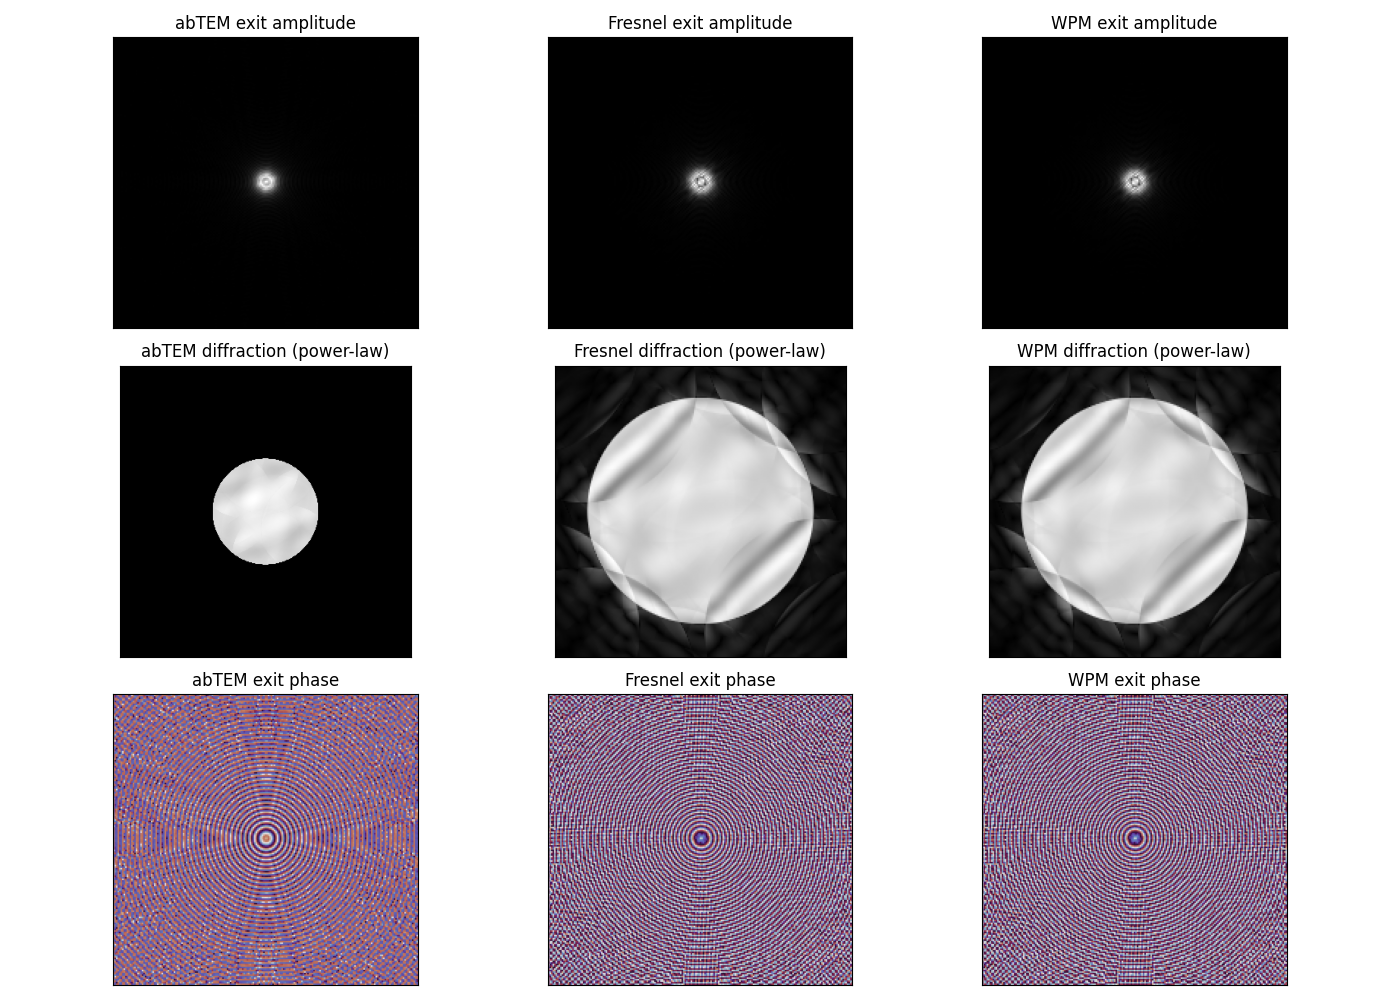

In [7]:
# --- Visualization (add phase row) ---
exit_a = np.abs(np.asarray(exit_wave_abtem)).squeeze()
exit_f = np.abs(np.asarray(exit_wave_fresnel)).squeeze()
exit_w = np.abs(np.asarray(exit_wave_wpm)).squeeze()

phase_a = np.angle(np.asarray(exit_wave_abtem)).squeeze()
phase_f = np.angle(np.asarray(exit_wave_fresnel)).squeeze()
phase_w = np.angle(np.asarray(exit_wave_wpm)).squeeze()

dp_a = np.asarray(diffraction_pattern_abtem).squeeze()
dp_f = np.asarray(diffraction_pattern_fresnel).squeeze()
dp_w = np.asarray(diffraction_pattern_wpm).squeeze()

dp_a_vis = np.power(dp_a, plot_gamma)
dp_f_vis = np.power(dp_f, plot_gamma)
dp_w_vis = np.power(dp_w, plot_gamma)

extent = [-max_angle_mrad, max_angle_mrad, -max_angle_mrad, max_angle_mrad]

fig, ax = plt.subplots(3, 3, figsize=(14, 10))
# amplitudes
ax[0, 0].imshow(exit_a, cmap='gray', origin='lower')
ax[0, 0].set_title('abTEM exit amplitude')
ax[0, 1].imshow(exit_f, cmap='gray', origin='lower')
ax[0, 1].set_title('Fresnel exit amplitude')
ax[0, 2].imshow(exit_w, cmap='gray', origin='lower')
ax[0, 2].set_title('WPM exit amplitude')

# diffractions
ax[1, 0].imshow(dp_a_vis, cmap='gray', origin='lower', extent=extent)
ax[1, 0].set_title('abTEM diffraction (power-law)')
ax[1, 1].imshow(dp_f_vis, cmap='gray', origin='lower', extent=extent)
ax[1, 1].set_title('Fresnel diffraction (power-law)')
ax[1, 2].imshow(dp_w_vis, cmap='gray', origin='lower', extent=extent)
ax[1, 2].set_title('WPM diffraction (power-law)')

# phases
ax[2, 0].imshow(phase_a, cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
ax[2, 0].set_title('abTEM exit phase')
ax[2, 1].imshow(phase_f, cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
ax[2, 1].set_title('Fresnel exit phase')
ax[2, 2].imshow(phase_w, cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
ax[2, 2].set_title('WPM exit phase')

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
